<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [1]:
!pip install js

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 997.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 2.3 MB/s eta 0:00:00
  Created wheel for js: filename=js-1.0-py3-none-any.whl size=2883 sha256=c5375bb0f6e82317b19c13b96b47a1887ddff04f0514d2ee0c8b2fb203d46f6b
  Stored in directory: /root/.cache/pip/wheels/77/dc/68/d580eaea0ef6137289a09dabe661f5df14951f5c29c08d443d
Successfully built js


We will import the following libraries for the lab


In [2]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

This function is to plot the confusion matrix.


In [3]:
def plot_confusion_matrix(y,y_predict):
    """This function plots the confusion matrix as a heatmap"""
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

## Load the dataframe


Load the data


In [4]:
# from js import fetch
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
# resp1 = await fetch(URL1)
# text1 = io.BytesIO((await resp1.arrayBuffer()).to_py())
data = pd.read_csv(URL1)

In [5]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [6]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
# resp2 = await fetch(URL2)
# text2 = io.BytesIO((await resp2.arrayBuffer()).to_py())
X = pd.read_csv(URL2)

In [7]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [8]:
Y = data['Class'].to_numpy()

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [9]:
# students get this
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

we can see we only have 18 test samples.


In [11]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [12]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [13]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [14]:
print("Tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

Tuned hyperparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [15]:
accuracy_logreg = logreg_cv.score(X_test, Y_test)
print("Accuracy (Logistic reression): ",accuracy_logreg)

Accuracy (Logistic reression):  0.8333333333333334


Lets look at the confusion matrix:


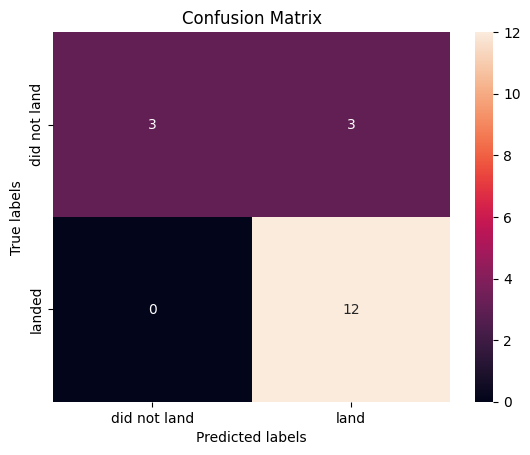

In [16]:
yhat_logreg=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat_logreg)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [17]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [18]:
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [19]:
print("Tuned hyperparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

Tuned hyperparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [20]:
accuracy_svm = svm_cv.score(X_test, Y_test)
print("Accuracy (SVM): ",accuracy_svm)

Accuracy (SVM):  0.8333333333333334


We can plot the confusion matrix


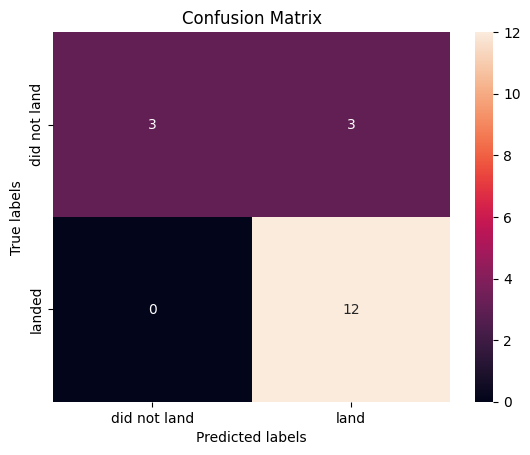

In [21]:
yhat_svm=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat_svm)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [22]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [ ]:
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, Y_train)

In [24]:
print("Tuned hyperparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

Tuned hyperparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}
accuracy : 0.875


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [25]:
accuracy_dt = tree_cv.score(X_test, Y_test)
print("Accuracy (Decision Tree): ",accuracy_dt)

Accuracy (Decision Tree):  0.6111111111111112


We can plot the confusion matrix


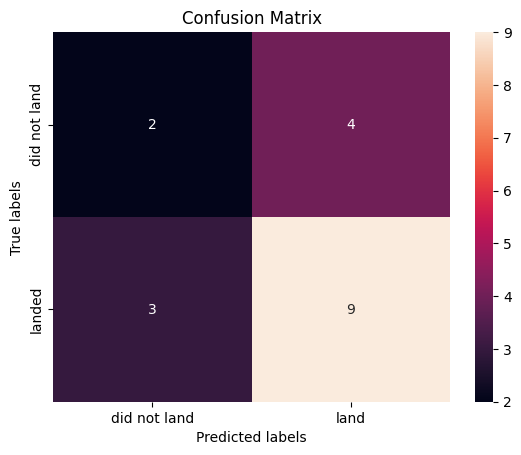

In [26]:
yhat_dt = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat_dt)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [27]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [28]:
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [29]:
print("Tuned hyperparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

Tuned hyperparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [30]:
accuracy_knn = knn_cv.score(X_test, Y_test)
print("Accuracy (KNN): ",accuracy_knn)

Accuracy (KNN):  0.8333333333333334


We can plot the confusion matrix


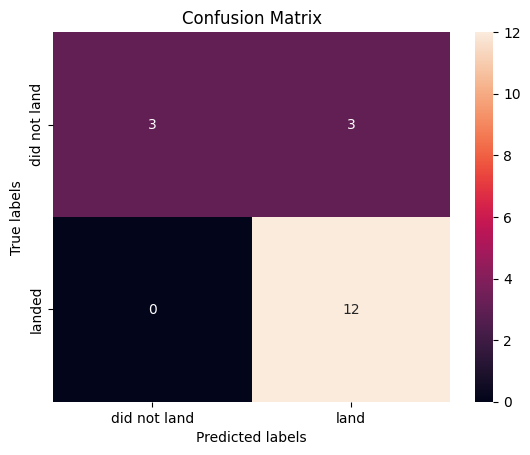

In [31]:
yhat_knn = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat_knn)

## TASK  12


Find the method performs best:


In [32]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calculate Accuracy
accuracy_scores_test = [
    accuracy_score(Y_test, yhat_logreg),
    accuracy_score(Y_test, yhat_svm),
    accuracy_score(Y_test, yhat_dt),
    accuracy_score(Y_test, yhat_knn)
]

# Calculate F1 scores
f1_scores_test = [
    f1_score(Y_test, yhat_logreg, average='binary'),
    f1_score(Y_test, yhat_svm, average='binary'),
    f1_score(Y_test, yhat_dt, average='binary'),
    f1_score(Y_test, yhat_knn, average='binary')
]

# Calculate Precision scores
precision_scores_test = [
    precision_score(Y_test, yhat_logreg, average='binary'),
    precision_score(Y_test, yhat_svm, average='binary'),
    precision_score(Y_test, yhat_dt, average='binary'),
    precision_score(Y_test, yhat_knn, average='binary')
]

# Calculate Recall scores
recall_scores_test = [
    recall_score(Y_test, yhat_logreg, average='binary'),
    recall_score(Y_test, yhat_svm, average='binary'),
    recall_score(Y_test, yhat_dt, average='binary'),
    recall_score(Y_test, yhat_knn, average='binary')
]


# Create a DataFrame to display the scores
scores = pd.DataFrame(
    np.array([accuracy_scores_test, f1_scores_test, precision_scores_test, recall_scores_test]),
    index=['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    columns=['LogReg', 'SVM', 'Tree', 'KNN']
)

# Display the scores DataFrame
scores

,LogReg,SVM,Tree,KNN
Accuracy,0.833333,0.833333,0.611111,0.833333
F1 Score,0.888889,0.888889,0.720000,0.888889
Precision,0.800000,0.800000,0.692308,0.800000
Recall,1.000000,1.000000,0.750000,1.000000


In [33]:
# Create dataframe for accuracy scores on training data through Gridsearch cv
accuracy_scores_train = [
    logreg_cv.best_score_,
    svm_cv.best_score_,
    tree_cv.best_score_,
    knn_cv.best_score_
]

scores_cv = pd.DataFrame(accuracy_scores_train, index=['LogReg', 'SVM', 'Tree', 'KNN'], columns=['Accuracy'])
scores_cv

,Accuracy
LogReg,0.846429
SVM,0.848214
Tree,0.875000
KNN,0.848214


- If we just look at the testing set, it is difficult to say which model is better, because the metrics for all algorithms (except decision tree) are similar.
- But if we look at the training accuracy, it looks like the **Decision Tree** algorithm performs best, with **89.3%** accuracy.

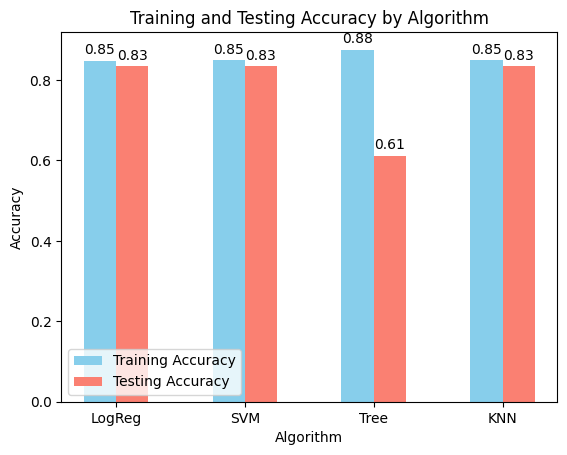

In [40]:
# Plotting accuracy on a bar chart with training and testing accuracy side by side, one bar for accuracy from CV and another bar for test accuracy

import matplotlib.pyplot as plt
import numpy as np

# Example accuracy values for demonstration purposes
training_accuracies = [logreg_cv.best_score_, svm_cv.best_score_, tree_cv.best_score_, knn_cv.best_score_]
testing_accuracies = [accuracy_logreg, accuracy_svm, accuracy_dt, accuracy_knn]
methods = ['LogReg', 'SVM', 'Tree', 'KNN']

x = np.arange(len(methods))  # Label locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots()

# Plot training accuracies with a new color scheme
rects1 = ax.bar(x - width/2, training_accuracies, width, label='Training Accuracy', color='skyblue')

# Plot testing accuracies with a new color scheme
rects2 = ax.bar(x + width/2, testing_accuracies, width, label='Testing Accuracy', color='salmon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Algorithm')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Testing Accuracy by Algorithm')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend(loc='lower left')

# Function to add labels on top of the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# fig.tight_layout()

plt.show()


## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/)


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
